# Лабораторна робота 2  
## Алгоритм самонавчання  

Спостерігається система, яка генерує послідовність незалежних нормально розподілених випадкових величин $x_1, \ldots, x_n$ з дисперсією 1. Система може перебувати в одному з чотирьох станів $k \in \{0, 1, 2, 3\}$. Математичне сподівання кожної величини залежить від поточного стану системи і дорівнює $a_k = k$, коли система знаходиться в стані $k$, $k \in \{0, 1, 2, 3\}$. Ймовірність того, що система перебуває в стані $k$, дорівнює $\frac{k+1}{10}$, $k \in \{0, 1, 2, 3\}$.  

### **Завдання**  

1. **Згенерувати** послідовність $n$ незалежних нормально розподілених випадкових величин з дисперсією 1 і математичним сподіванням, яке з ймовірністю $\frac{k+1}{10}$ дорівнює $k$, $k \in \{0, 1, 2, 3\}$.  

2. **За допомогою алгоритму самонавчання** отримати оцінки ймовірностей $p_K(k)$ і параметрів $a_k$, $k \in \{0, 1, 2, 3\}$.  
   *Умовою зупинки алгоритму вважати наступне:*  
   - оцінки параметрів не змінились,  
   - оцінки ймовірностей змінились менше ніж на 0.001.  
   *Алгоритм має працювати для довільного $n$.*  

3. **Проаналізувати** поведінку алгоритму в залежності від $n$ і початкових оцінок ймовірностей і параметрів.  


In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [2]:
def generate_data(n, p, a):
    """
    Генерує вибірку з нормально розподілених величин за ймовірностями та середніми.
    """
    states = np.random.choice([0,1,2,3], size=n, p=p)
    x = np.array([np.random.normal(a[k], 1) for k in states])
    return x, states

def log_pdf(x, m):
    """
    Логарифм щільності нормального розподілу з дисперсією 1.
    """
    return -0.5*(x - m)**2 - 0.5*np.log(2*np.pi)

def e_step(x, p_est, a_est):
    """
    E-крок: розрахунок апостеріорних ймовірностей.
    """
    n = len(x)
    K = len(p_est)
    log_weights = np.zeros((n,K))
    for k in range(K):
        log_weights[:, k] = np.log(p_est[k]) + log_pdf(x, a_est[k])
    max_log_w = np.max(log_weights, axis=1, keepdims=True)
    log_sum_exp = max_log_w + np.log(np.sum(np.exp(log_weights - max_log_w), axis=1, keepdims=True))
    w = np.exp(log_weights - log_sum_exp)
    return w

def m_step(x, w):
    """
    M-крок: оновлення ймовірностей та середніх.
    """
    n = len(x)
    nk = w.sum(axis=0)
    p_est = nk / n
    a_est = (w.T @ x) / nk
    return p_est, a_est

def self_learning(x, tol=0.001, max_iter=10000, p_init=None, a_init=None):
    """
    Алгоритм самонавчання для оцінки ймовірностей та середніх.
    """
    K = 4
    if p_init is None:
        p_init = np.random.rand(K)
        p_init = p_init / p_init.sum()
    if a_init is None:
        # Ініціалізуємо середні за квантилями
        qs = np.quantile(x, [0.2, 0.4, 0.6, 0.8])
        a_init = qs
    
    p_est = p_init.copy()
    a_est = a_init.copy()
    
    for iteration in range(max_iter):
        old_p = p_est.copy()
        old_a = a_est.copy()
        
        w = e_step(x, p_est, a_est)
        p_est, a_est = m_step(x, w)
        
        p_change = np.linalg.norm(p_est - old_p)
        a_change = np.linalg.norm(a_est - old_a)
        
        if (p_change < tol) and (a_change < tol):
            break
                
    # Відсортуємо компоненти за середніми для зручності
    idx = np.argsort(a_est)
    p_est = p_est[idx]
    a_est = a_est[idx]
    
    converged = (p_change < tol) and (a_change < tol)
    return p_est, a_est, iteration, converged

def run_experiment(n_values, num_repeats, p_true, a_true, tol=0.001, max_iter=10000):
    """
    Проводить експеримент для різних значень n та кількості повторів.
    Зберігає лише найкращий результат для кожного n.
    """
    best_results = []
    
    for n in n_values:
        print(f"Розмір вибірки n = {n}")
        best_p_error = np.inf
        best_a_error = np.inf
        best_result = None
        
        for repeat in range(num_repeats):
            # Генерація даних
            x, states = generate_data(n, p_true, a_true)
            
            # Початкові значення
            p_init = np.random.rand(4)
            p_init /= p_init.sum()
            a_init = np.random.uniform(min(x), max(x), size=4)
            
            # Запуск самонавчання
            p_est, a_est, iters, converged = self_learning(
                x, tol=tol, max_iter=max_iter, p_init=p_init, a_init=a_init
            )
            
            if not converged:
                continue
            
            # Обчислення похибки
            p_error = np.linalg.norm(p_est - p_true)
            a_error = np.linalg.norm(a_est - a_true)
            total_error = p_error + a_error
            
            # Оновлення найкращого результату
            if total_error < (best_p_error + best_a_error):
                best_p_error = p_error
                best_a_error = a_error
                best_result = {
                    'n': n,
                    'repeat': repeat+1,
                    'p_init': p_init,
                    'a_init': a_init,
                    'p_est': p_est,
                    'a_est': a_est,
                    'p_error': p_error,
                    'a_error': a_error,
                    'iterations': iters,
                    'converged': converged
                }
                
        if best_result is not None:
            best_results.append(best_result)
            print(f"  Найкращий результат для n={n}: Повтор {best_result['repeat']}, Похибка p={best_result['p_error']:.4f}, Похибка a={best_result['a_error']:.4f}, Ітерації={best_result['iterations']}")
        else:
            print(f"  Для n={n} не було збіжних результатів.")
                    
    return pd.DataFrame(best_results)

def analyze_results(df, p_true, a_true):
    """
    Аналізує результати експериментів.
    """
    if df.empty:
        print("Немає результатів для аналізу.")
        return
    
    summary = pd.DataFrame({
        'n': df['n'],
        'p_error': df['p_error'],
        'a_error': df['a_error'],
        'iterations': df['iterations'],
        'converged': df['converged']
    })
    
    print("\nСумарні результати експериментів:")
    print(summary)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1,2,1)
    plt.plot(summary['n'], summary['p_error'], '-o', label='Похибка p')
    plt.xlabel('Розмір вибірки n')
    plt.ylabel('Похибка p')
    plt.title('Похибка p від n')
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(summary['n'], summary['a_error'], '-o', color='orange', label='Похибка a')
    plt.xlabel('Розмір вибірки n')
    plt.ylabel('Похибка a')
    plt.title('Похибка a від n')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(6,4))
    plt.plot(summary['n'], summary['iterations'], '-o', color='green')
    plt.xlabel('Розмір вибірки n')
    plt.ylabel('Кількість ітерацій')
    plt.title('Кількість ітерацій від n')
    plt.grid(True)
    plt.show()
    
    convergence_rate = summary['converged'].mean()
    print(f"\nЗагальний коефіцієнт збіжності: {convergence_rate*100:.2f}%")
    
    plt.figure(figsize=(6,4))
    plt.bar(summary['n'], summary['converged'], color='red')
    plt.xlabel('Розмір вибірки n')
    plt.ylabel('Збіжність')
    plt.title('Збіжність алгоритму від n')
    plt.ylim(0,1.05)
    plt.yticks([0, 0.5, 1], ['Не збігся', 'Частково', 'Збігся'])
    plt.grid(axis='y')
    plt.show()
    
    print("\nСередні оцінки параметрів:")
    for k in range(4):
        estimated_means = df['a_est'].apply(lambda a: a[k])
        print(f"  a_{k}: Середнє = {estimated_means.mean():.4f}, Стандартне відхилення = {estimated_means.std():.4f}")
    
    print("\nПорівняння з істинними параметрами:")
    for k in range(4):
        print(f"  a_{k}: Істинне = {a_true[k]}, Середнє оцінене = {df['a_est'].apply(lambda a: a[k]).mean():.4f}")

Розмір вибірки n = 1000
  Найкращий результат для n=1000: Повтор 61, Похибка p=0.0451, Похибка a=0.3871, Ітерації=112
Розмір вибірки n = 5000
  Найкращий результат для n=5000: Повтор 40, Похибка p=0.0556, Похибка a=0.2962, Ітерації=42
Розмір вибірки n = 10000
  Найкращий результат для n=10000: Повтор 21, Похибка p=0.1641, Похибка a=0.1742, Ітерації=438
Розмір вибірки n = 50000
  Найкращий результат для n=50000: Повтор 12, Похибка p=0.0392, Похибка a=0.1214, Ітерації=10

Сумарні результати експериментів:
       n   p_error   a_error  iterations  converged
0   1000  0.045051  0.387052         112       True
1   5000  0.055568  0.296185          42       True
2  10000  0.164128  0.174165         438       True
3  50000  0.039206  0.121388          10       True


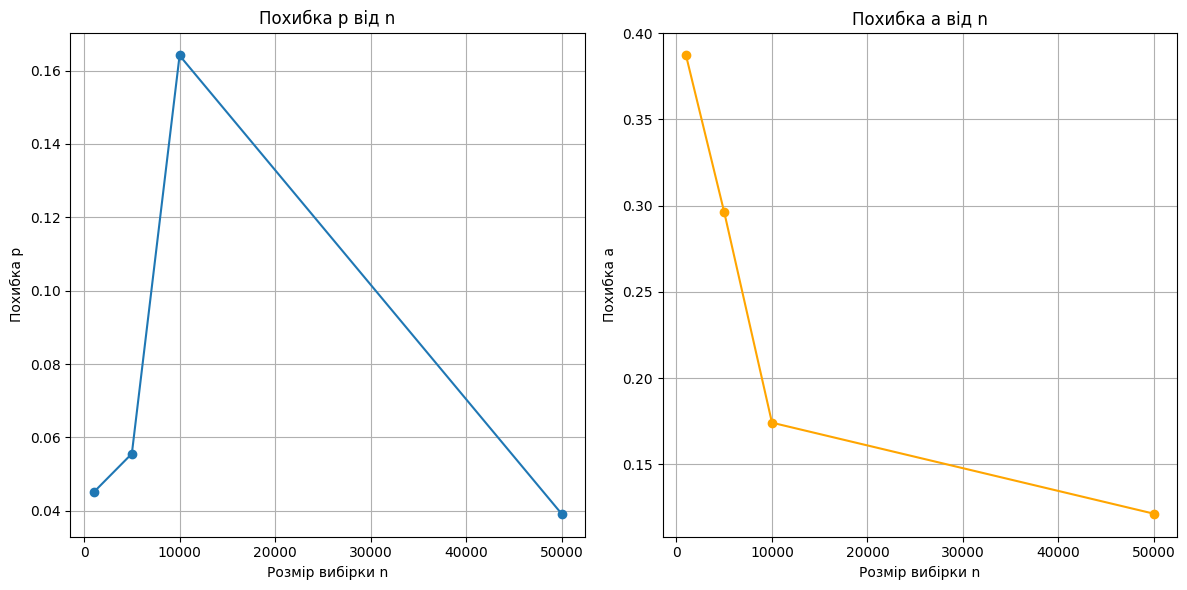

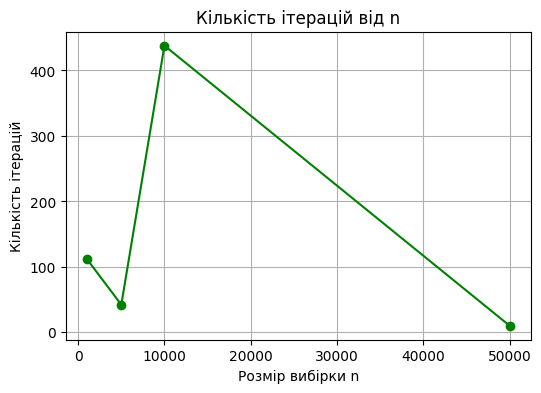


Загальний коефіцієнт збіжності: 100.00%


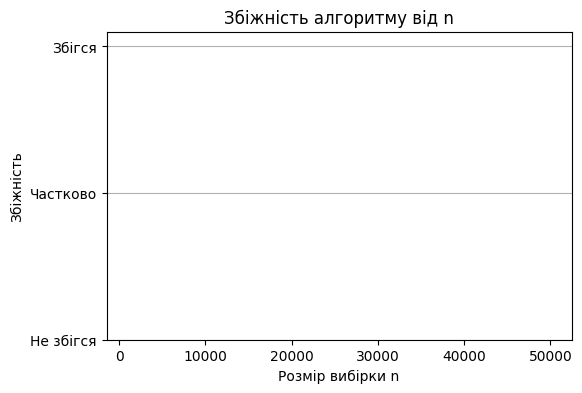


Середні оцінки параметрів:
  a_0: Середнє = -0.1127, Стандартне відхилення = 0.1668
  a_1: Середнє = 0.9832, Стандартне відхилення = 0.1764
  a_2: Середнє = 1.9151, Стандартне відхилення = 0.0412
  a_3: Середнє = 2.9415, Стандартне відхилення = 0.0458

Порівняння з істинними параметрами:
  a_0: Істинне = 0, Середнє оцінене = -0.1127
  a_1: Істинне = 1, Середнє оцінене = 0.9832
  a_2: Істинне = 2, Середнє оцінене = 1.9151
  a_3: Істинне = 3, Середнє оцінене = 2.9415


In [3]:
# Істинні параметри
p_true = np.array([0.1, 0.2, 0.3, 0.4])
a_true = np.array([0, 1, 2, 3])

# Параметри експерименту
n_values = [1000, 5000, 10000, 50000]
num_repeats = 100
tol = 0.001
max_iter = 50000

# Проведення експерименту
df_results = run_experiment(n_values, num_repeats, p_true, a_true, tol=tol, max_iter=max_iter)

# Аналіз результатів
analyze_results(df_results, p_true, a_true)

In [4]:
print("\nНайкращі результати для кожного n:")
df_results


Найкращі результати для кожного n:


,n,repeat,p_init,a_init,p_est,a_est,p_error,a_error,iterations,converged
0,1000,61,"[0.3464095529286361, 0.2427427132757268, 0.28229989091655733, 0.1285478428790799]","[4.751287756879135, -0.18698722532323675, -1.7918502690685696, 0.615527732356826]","[0.07615119669527658, 0.2082928961917559, 0.3329873959797618, 0.38256851113320556]","[-0.3391293654730141, 1.1520925747396558, 1.9413393656039808, 2.909296430607327]",0.045051,0.387052,112,True
1,5000,40,"[0.1875920953989122, 0.24372819922943106, 0.1921072078536298, 0.3765724975180269]","[0.4032128127749699, 1.6111521729634473, -1.1203687604872263, 3.591074625274429]","[0.07215011414943896, 0.17462240828183606, 0.33782913312077617, 0.4153983444479496]","[-0.1270642194988063, 0.7407718281877749, 1.9580828777419095, 2.948778246981533]",0.055568,0.296185,42,True
2,10000,21,"[0.44513353824816787, 0.3218566460096735, 0.008158625473718876, 0.22485119026843986]","[-1.8553413380609016, -3.2032463532943867, -0.43568902219121775, 4.15717103143923]","[0.08846551213419684, 0.2532493420078009, 0.17167342623894363, 0.48661171961905647]","[-0.03039904350509173, 1.0611251787476914, 1.8713382127060507, 2.904506008311664]",0.164128,0.174165,438,True
3,50000,12,"[0.22234786445390203, 0.2775607596977474, 0.21587441559013254, 0.2842169602582181]","[0.5463868775162029, 2.815630759756858, -0.42182210999936665, 1.5709215039431603]","[0.10506064244030476, 0.1667004259430662, 0.31552418909750807, 0.41271474251912216]","[0.04594663833960678, 0.97867377856142, 1.8897371107899505, 3.0033666570888267]",0.039206,0.121388,10,True
